# building micrograd

Building a system that can do a forward pass, backward pass, updates and define networks all from scratch, follow along with Andrej Karpathy's Zero to Hero series ([video 1](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ))

In [1]:
import torch 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [14]:
from micrograd.engine import Value
import numpy as np

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f

h = 2+f

print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

h.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db


g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db



24.7041
138.8338
645.5773
1855.7638
8368.6414
13200.6356
58145.8309


In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def f(x):
    return x**2 + 2*x + 1

In [17]:
f(3)

16

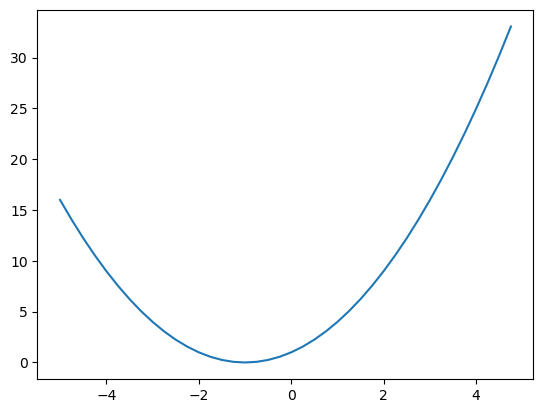

In [18]:
xs = np.arange(-5,5,0.25)
ys = f(xs)

plt.plot(xs,ys)

In [19]:
a = 2.0
b = -3.0
c = 10.0
h=0.001


d1 = a*b + c

c+=h
d2 = a*b + c

print(f"d1: {d1}, d2: {d2:.4f}, slope: {(d2-d1)/h:.4f}")

d1: 4.0, d2: 4.0010, slope: 1.0000


In [20]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) #making it so  you can add numbers even if they're not Value objects already
        out = Value(data = self.data + other.data, _children = (self, other), _op = '+') 
        def _backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self,other): #if a.__add__(b) fails, python automatically tries b.__radd__(a)
        return self+other
    
    def __sub__(self, other):
        return self + (-1*other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)#making it so  you can multiply numbers even if they're not Value objects already
        out = Value(data = self.data * other.data, _children = (self, other), _op = '*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
            
        return out
    
    def __rmul__(self, other): #if a.__mul__(b) fails, python automatically tries b.__rmul__(a)
        return self*other
    
    def __truediv__(self,other):
        return self * other **-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        # other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data**other, _children = (self,), _op = f'**{other}')
        def _backward():
            self.grad += other * self.data**(other-1.0) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(np.exp(x), _children = (self,), _op = 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (np.exp(2*x)-1)/(np.exp(2*x)+1)
        out = Value(t, _children = (self,), _op = 'tanh')
        def _backward():
            self.grad += out.grad*(1-t**2) # d/dx (tanh(x)) = 1 - tanh(x)**2 
        out._backward = _backward
        return out
    
    def backward(self):

        self.grad = 1.0
        topological_order = []
        visited = set()
        def build_topological_order(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topological_order(child)
                topological_order.append(v)
        
        build_topological_order(self)

        for node in reversed(topological_order):
            node._backward()
                
    

In [21]:
Value(3).__pow__(3)

Value(data = 27)

In [22]:
z = Value(2.0)
print(z.tanh())

print(np.tanh(2.0))

Value(2)+1

Value(data = 0.9640275800758169)
0.9640275800758169


Value(data = 3)

In [23]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [24]:
# example with neuron
# inputs
x1 = Value(1.0, label='x1')
x2 = Value(-2.0, label='x2')

# weights
w1 = Value(2.0, label='w1')
w2 = Value(-3.0, label='w2')

# bias
b = Value(-7.5, label='b')

# weighted components
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

# summation
x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1w1 + x2w2'
n = x1w1_plus_x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'


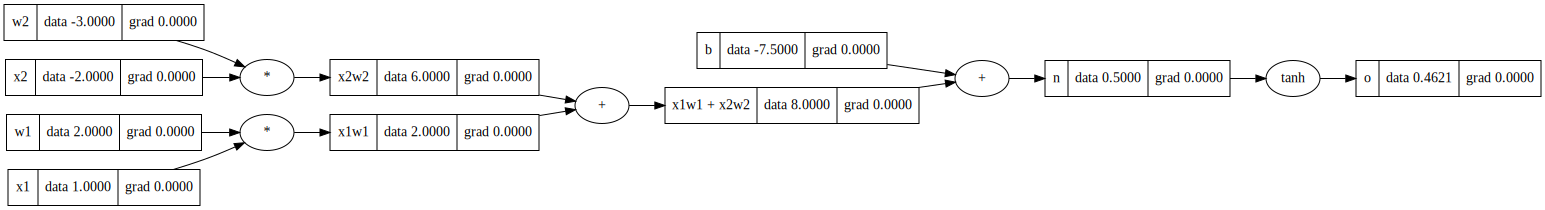

In [25]:
draw_dot(o) 

In [13]:
o.backward()

In [14]:
# example with neuron
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# weighted components
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

# summation
x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1w1 + x2w2'
n = x1w1_plus_x2w2 + b; n.label = 'n'


e = (2*n).exp(); e.label = 'e'
o =  (e-1)/(e+1);   o.label = 'o'
# n.tanh(); o.label = 'o'


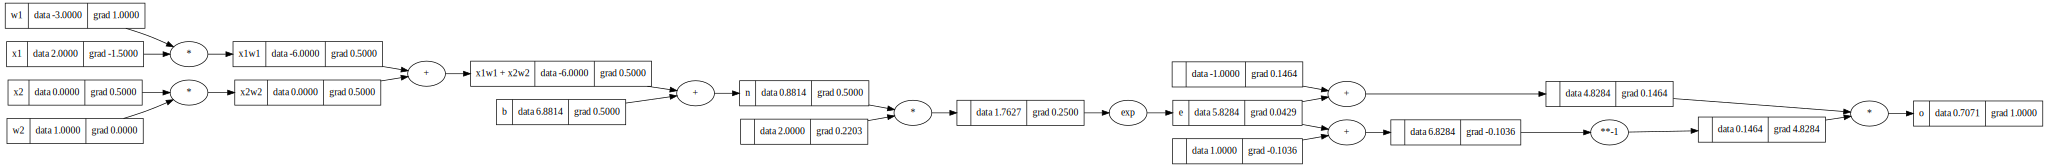

In [15]:
o.backward()
draw_dot(o)

In [26]:
import torch as t
x1 = t.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = t.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = t.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = t.Tensor([1.0]).double() ; w2.requires_grad = True
b = t.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = t.tanh(n)

print(o.data.item())
o.backward()

print('___')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
___
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [27]:
class Neuron:
    def __init__(self, nin):
        self.W = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))

    def __repr__(self) -> str:
        return f'W: {self.W}\n b:{self.b}'
    
    def __call__(self,x):
        # w*x +b
        # act = np.dot(self.W, x)+self.b
        # print(f"activation with np.dot is {act}")
        act = sum((wi*xi for wi, xi in zip(self.W, x) ) , self.b ) #second argument of sum here is 'start', so this is equal to adding self.b but a bit more efficient
        # print(f"activation with zip is {act}")
        out = act.tanh()

        return out
    
    def parameters(self):
        return self.W + [self.b]
    

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
  
    def parameters(self):
        params = [p for neuron in self.neurons for p in neuron.parameters()]
        #   equivalent but more readable:
        # params = []
        # for n in self.neurons:
        #     current_params = n.params
        #     params.extend(current_params)
        return params


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin]+nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = [p for layer in self.layers for p in layer.parameters()]
        return params

In [1]:
draw_dot(mlp(x))

NameError: name 'draw_dot' is not defined

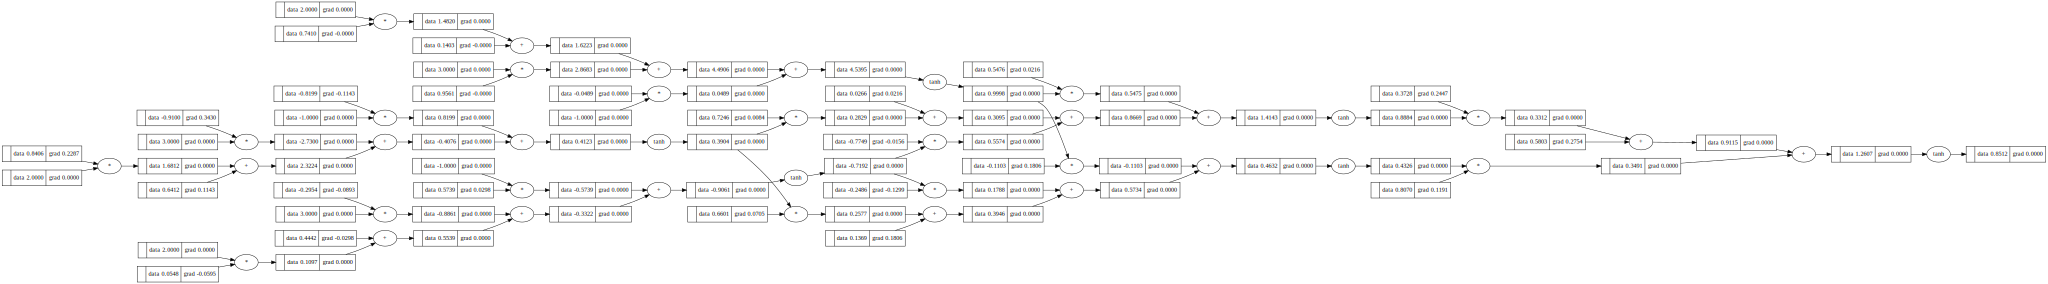

In [ ]:
draw_dot(mlp(x))

In [196]:
num_epochs = 100
losses = []
step_size = 0.01

mlp = MLP(3, [3,2,1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]




for n in range(num_epochs):

    #calculate predictions of model and corresponding loss
    ypreds = [mlp(x) for x in xs]
    loss = sum([(ypred-y)**2 for y, ypred in zip(ys, ypreds)] )

    #rezeroing gradients
    for p in mlp.parameters():
        p.grad = 0

    #backward pass - calculating gradients    
    loss.backward()

    #updating parameters
    for p in mlp.parameters():
        p.data-=step_size*p.grad

    #for visibility of loss
    if (n+1)%10==0 or n==0:
        print(f'epoch {n+1}/{num_epochs}: loss is {loss}')  
    losses.append((n,loss.data)) 

epoch 1/100: loss is Value(data = 3.560146307781551)
epoch 10/100: loss is Value(data = 1.3595739485917622)
epoch 20/100: loss is Value(data = 0.6145752357980397)
epoch 30/100: loss is Value(data = 0.35704469622615453)
epoch 40/100: loss is Value(data = 0.24261512146715467)
epoch 50/100: loss is Value(data = 0.180788517355547)
epoch 60/100: loss is Value(data = 0.14283356673714698)
epoch 70/100: loss is Value(data = 0.11743154756133392)
epoch 80/100: loss is Value(data = 0.09935343526335166)
epoch 90/100: loss is Value(data = 0.08588656675946943)
epoch 100/100: loss is Value(data = 0.07549597954916465)


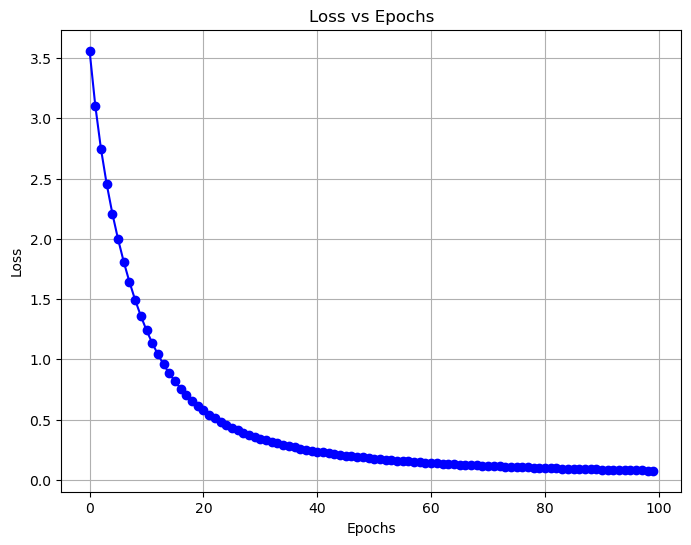

In [197]:
epochs, loss_values = zip(*losses)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='blue')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

In [198]:
ypreds

[Value(data = 0.8833488460360642),
 Value(data = -0.9176855516158147),
 Value(data = -0.8299893360544123),
 Value(data = 0.8381074629266855)]